# Predicting Insurance Risk using Machine Learning (ML)

## 1.1 Background
Historically, the business has used traditional risk quantification methods in order to predict the risk of offering an insurance policy to a potential customer. The risk is the probability of a customer filing a claim within one year of policy purchase, resulting in a loss for the business.

## 1.2 The challenge
Traditional methods have been used for a long time, and stakeholders are not yet confident in the ability of ML methodology. We need to demonstrate how and why adopting ML can provide additional value in an easy to understand manner.

## 1.3 Objective
This project aims to:
- Synthesise a dataset of 10,000 customers that is akin to a real-world insurance company dataset.
- Provide Exploratory Data Analysis (EDA) and context behind pre-processing of the data.
- Develop an ML model proof of concept that will predict the risk profile of each customer, to determine product price.
- Explain how the model could be used to ensure only 5% of people that buy a policy would claim on their policy.
- Provide next steps to cover what steps need to be taken to take the proof of concept into production.

## 1.4 Impact
This notebook aims to provide evidence of the potential of ML methodology to add value to the business, improving accuracy compared with traditional risk quantification methods. Transparency of the work behind the proof of concept aims to aid stakeholder understanding, increasing knowledge and encouraging the organisation to embrace ML technology.

## 2. Data Synthesis

A dataset with 40 features (the inputs) and 1 label (the output) is synthesised. For the label, as most people may not claim, an imbalance is created with only 10% having a 1. Missing values and some duplicates are added, to ensure it has some of the data quality challenges that a real-world dataset might have.

As we don't have the usual methodology for deciding risk to hand, a simple example combining vehicle age and the number of claims in the past five years is used to create our existing risk to claim flag that we will try and predict.

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import (train_test_split, StratifiedKFold)
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

# Define size of dataset and set random seed for reproducibility
n = 10000
seed=np.random.seed(42)

# Define numerical features
age = np.random.randint(18, 90, n)  # random number in range
income = np.random.lognormal(mean=10, sigma=1, size=n)  # skewed distribution / exp(mean + (sigma*2 /2))
credit_score = np.random.normal(loc=680, scale=50, size=n)  # normal distribution, loc=mean, scale=standard deviation
dependents = np.random.poisson(lam=1.5, size=n)  # event count, lam=mean rate
annual_premium = np.random.normal(loc=750, scale=150, size=n)
vehicle_age = np.random.randint(0, 20, n)
claim_amount_last_year = np.random.exponential(scale=300, size=n)  # rare high values, clustered low
total_claims_past_5_years = np.random.poisson(1.2, n)
time_employed = np.random.randint(0, 15, n)
distance_to_work = np.random.normal(10, 5, n)
vehicle_value = np.random.normal(15000, 5000, n)
years_with_license = np.random.randint(1, 70, n)
coverage_limit = np.random.normal(loc=30000, scale=15000, size=n)

# Define categorical features
gender = np.random.choice(['male', 'female', 'other'], n) # random selection from list
marital_status = np.random.choice(['single', 'married', 'divorced'], n)
education = np.random.choice(['high School', 'college', 'bachelor’s', 'master’s', 'phd'], n)
occupation = np.random.choice(['teacher', 'engineer', 'nurse', 'artist', 'data scientist'], n)
vehicle_type = np.random.choice(['saloon', 'hatch-back', 'suv', 'motorcycle', 'van'], n)
policy_type = np.random.choice(['third_party', 'comprehensive'], n)
employment_type = np.random.choice(['full_time', 'part-time', 'self-employed', 'unemployed', 'retired'], n)
previous_insurer = np.random.choice(['a', 'b', 'c'], n)
accident_history = np.random.choice(['none', 'minor', 'major'], n)
has_previous_claims = np.random.choice([0, 1], n)
region = np.random.choice(["scotland", "northern ireland", "ireland", "england", "wales"])

# Define ordinal features
health_status = np.random.randint(1, 6, n)
driving_record = np.random.choice(['poor', 'fair', 'good', 'excellent'], n)
home_ownership = np.random.choice(['renting', 'owned', 'mortgaged'], n)
customer_loyalty_rating = np.random.randint(1, 6, n)
vehicle_condition = np.random.choice(['poor', 'fair', 'good', 'excellent'], n)
payment_timeliness = np.random.choice(['always', 'mostly', 'occasionally', 'never'], n)
claim_satisfaction_rating = np.random.randint(1, 6, n)
policy_category = np.random.choice(['new', 'short_term', 'long_term'], n, p=[0.2, 0.4, 0.4])

# Boolean features
has_anti_theft_device = np.random.choice([0, 1], n)
owns_garage = np.random.choice([0, 1], n)
has_additional_drivers = np.random.choice([0, 1], n)
is_smoker = np.random.choice([0, 1], n)
has_medical_conditions = np.random.choice([0, 1], n)
uses_vehicle_for_commute = np.random.choice([0, 1], n)
uses_vehicle_for_business = np.random.choice([0, 1], n)
modifications_to_vehicle = np.random.choice([0, 1], n, p=[0.85, 0.15])

# Example risk score based on vehicle age and recent claims
risk_score = ((vehicle_age + total_claims_past_5_years) / 25)
risk_to_claim = (risk_score > 0.5).astype(int)

# Combine into DataFrame
df = pd.DataFrame({
    'age': age,
    'income': income,
    'credit_score': credit_score,
    'dependents': dependents,
    'annual_premium': annual_premium,
    'vehicle_age': vehicle_age,
    'claim_amount_last_year': claim_amount_last_year,
    'total_claims_past_5_years': total_claims_past_5_years,
    'time_employed': time_employed,
    'distance_to_work': distance_to_work,
    'vehicle_value': vehicle_value,
    'years_with_license': years_with_license,
    'coverage_limit': coverage_limit,

    'gender': gender,
    'marital_status': marital_status,
    'education': education,
    'occupation': occupation,
    'vehicle_type': vehicle_type,
    'policy_type': policy_type,
    'employment_type': employment_type,
    'previous_insurer': previous_insurer,
    'accident_history': accident_history,
    'has_previous_claims': has_previous_claims,
    'region': region,

    'health_status': health_status,
    'driving_record': driving_record,
    'home_ownership': home_ownership,
    'customer_loyalty_rating': customer_loyalty_rating,
    'vehicle_condition': vehicle_condition,
    'payment_timeliness': payment_timeliness,
    'claim_satisfaction_rating': claim_satisfaction_rating,
    'policy_category': policy_category,

    'has_anti_theft_device': has_anti_theft_device,
    'owns_garage': owns_garage,
    'has_additional_drivers': has_additional_drivers,
    'is_smoker': is_smoker,
    'has_medical_conditions': has_medical_conditions,
    'uses_vehicle_for_commute': uses_vehicle_for_commute,
    'uses_vehicle_for_business': uses_vehicle_for_business,
    'modifications_to_vehicle': modifications_to_vehicle,

    'risk_to_claim': risk_to_claim
})

# Round values as needed
df['income'] = df['income'].round(2)
df['credit_score'] = df['credit_score'].round().astype(int)
df['annual_premium'] = df['annual_premium'].round().astype(int)
df['claim_amount_last_year'] = df['claim_amount_last_year'].round(0)
df['distance_to_work'] = df['distance_to_work'].round(1)
df['vehicle_value'] = df['vehicle_value'].round(-2)  # nearest hundred
df['coverage_limit'] = df['coverage_limit'].round(-3) 

# Introduce some missing values to replicate real data
for col in df.columns:
    df.loc[df.sample(frac=0.05).index, col] = np.nan

# Add 1% duplicates to replicate real data
dupes = df.sample(frac=0.01)
df = pd.concat([df, dupes], ignore_index=True)

The first five rows of the table are visualised as a sense check.

In [260]:
print(df.shape[1])
pd.set_option('display.max_columns', 50)
df.head()

41


,age,income,credit_score,dependents,annual_premium,vehicle_age,claim_amount_last_year,total_claims_past_5_years,time_employed,distance_to_work,vehicle_value,years_with_license,coverage_limit,gender,marital_status,education,occupation,vehicle_type,policy_type,employment_type,previous_insurer,accident_history,has_previous_claims,region,health_status,driving_record,home_ownership,customer_loyalty_rating,vehicle_condition,payment_timeliness,claim_satisfaction_rating,policy_category,has_anti_theft_device,owns_garage,has_additional_drivers,is_smoker,has_medical_conditions,uses_vehicle_for_commute,uses_vehicle_for_business,modifications_to_vehicle,risk_to_claim
0,69.0,14103.95,608.0,4.0,581.0,15.0,49.0,2.0,5.0,14.5,9500.0,NaN,NaN,other,divorced,phd,engineer,saloon,comprehensive,unemployed,c,minor,0.0,wales,5.0,excellent,renting,1.0,excellent,mostly,1.0,short_term,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,NaN,NaN,691.0,1.0,503.0,19.0,1932.0,0.0,11.0,15.5,15800.0,43.0,24000.0,male,divorced,high School,engineer,van,comprehensive,unemployed,b,none,0.0,wales,1.0,good,owned,5.0,fair,always,4.0,short_term,0.0,0.0,0.0,1.0,1.0,1.0,NaN,1.0,1.0
2,89.0,142734.96,NaN,1.0,668.0,10.0,743.0,0.0,12.0,14.4,15200.0,53.0,35000.0,other,married,high School,nurse,suv,comprehensive,retired,c,NaN,0.0,wales,2.0,poor,mortgaged,3.0,good,never,4.0,long_term,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,78.0,13806.12,757.0,1.0,838.0,17.0,NaN,0.0,7.0,15.5,13500.0,22.0,0.0,other,single,phd,teacher,hatch-back,third_party,full_time,a,major,1.0,wales,2.0,poor,owned,1.0,fair,never,3.0,new,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
4,38.0,87570.37,696.0,2.0,685.0,16.0,1.0,2.0,10.0,14.9,9900.0,36.0,39000.0,other,married,phd,engineer,van,third_party,unemployed,c,minor,1.0,wales,5.0,excellent,mortgaged,3.0,fair,never,2.0,long_term,1.0,NaN,0.0,1.0,0.0,1.0,1.0,1.0,1.0


## 3. Data Exploration and Preprocessing

3.1 In this step any duplicates and rows with blank labels (the output) need to be removed. A threshold of 30% of missing data is set for each feature - if higher than this, the feature is not used; if lower than this, the missing data is imputed with the mode (if categorical), the mean (if normal distributed continuous data), or the median (if non-normally distributed continuous data).

In [261]:
# Print number of rows and data types
print(f"\nNumber of columns before preprocessing:", df.shape[1])
print(f"Number of rows before preprocessing:", len(df))

# Check for duplicates and remove them
duplicates = df.duplicated()
print(f"\nNumber of duplicates found: {duplicates.sum()}")
df[duplicates].head()

before = df.shape[0]
df = df.drop_duplicates(keep='last')
after = df.shape[0]

print(f"Number of duplicates removed: {before - after}")

# Remove rows with blank label values, do not use imputation
df = df.dropna(subset=['risk_to_claim'])

# Account for NaN values - imputation or drop column
# Use mean for continuous data normal distribution
# Use median for continous data non-normal distribution
# Use mode for categorical data

# Threshold for dropping columns
missing_thresh = 0.3
missing_percent = df.isna().mean()

# Drop columns with > 40% missing
df = df.drop(columns=missing_percent[missing_percent > missing_thresh].index)

# Initialize counters
mean_imputations = {}
median_imputations = {}
mode_imputations = {}

# Initialize counters
mean_total = 0
median_total = 0
mode_total = 0

for col in df.columns:
    missing_count = df[col].isna().sum()
    if missing_count == 0:
        continue

    if df[col].dtype in [np.float64, np.int64]:
        skew = df[col].skew()
        if abs(skew) < 0.5:
            impute_val = df[col].mean()
            df[col] = df[col].fillna(impute_val)
            mean_total += missing_count
        else:
            impute_val = df[col].median()
            df[col] = df[col].fillna(impute_val)
            median_total += missing_count
    else:
        impute_val = df[col].mode(dropna=True)[0]
        df[col] = df[col].fillna(impute_val)
        mode_total += missing_count

# Final report
print("\nImputed value counts:")
print(f"Mean imputations: {mean_total}")
print(f"Median imputations: {median_total}")
print(f"Mode imputations: {mode_total}")

# Print number of rows and data types
print(f"\nNumber of columns after preprocessing:", df.shape[1])
print(f"Number of rows after preprocessing:", len(df))



Number of columns before preprocessing: 41
Number of rows before preprocessing: 10100

Number of duplicates found: 100
Number of duplicates removed: 100

Imputed value counts:
Mean imputations: 9508
Median imputations: 2377
Mode imputations: 7150

Number of columns after preprocessing: 41
Number of rows after preprocessing: 9500


3.2 Features are prepared for visualisation by ensuring they are in the right format. The processed data is then visualised in groups to enable easy analysis.

Ordinal fixed: ['health_status', 'customer_loyalty_rating', 'claim_satisfaction_rating']
Boolean fixed: ['has_anti_theft_device', 'owns_garage', 'has_additional_drivers', 'is_smoker', 'has_medical_conditions', 'uses_vehicle_for_commute', 'uses_vehicle_for_business', 'has_previous_claims']


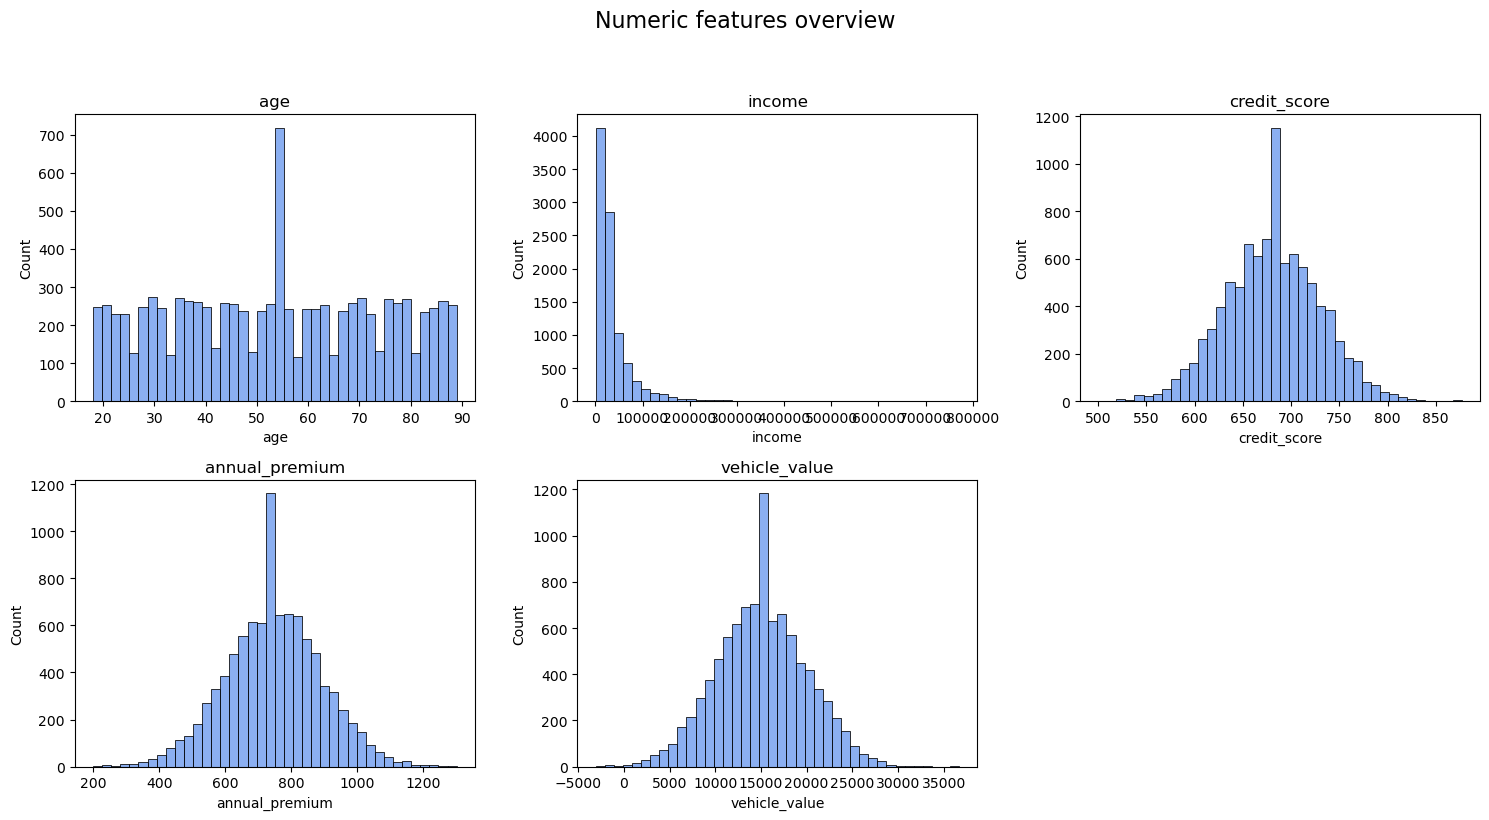

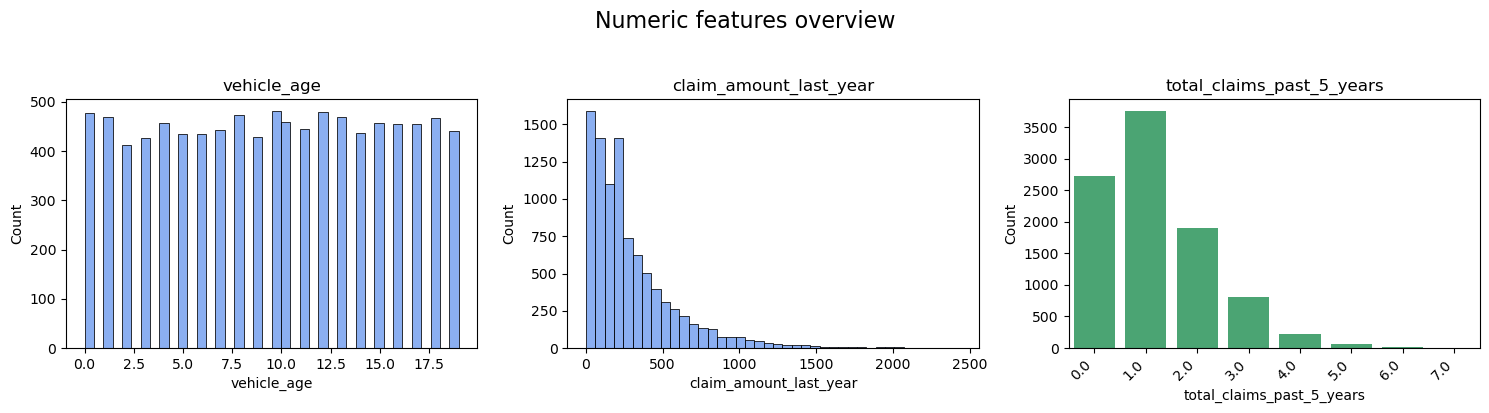

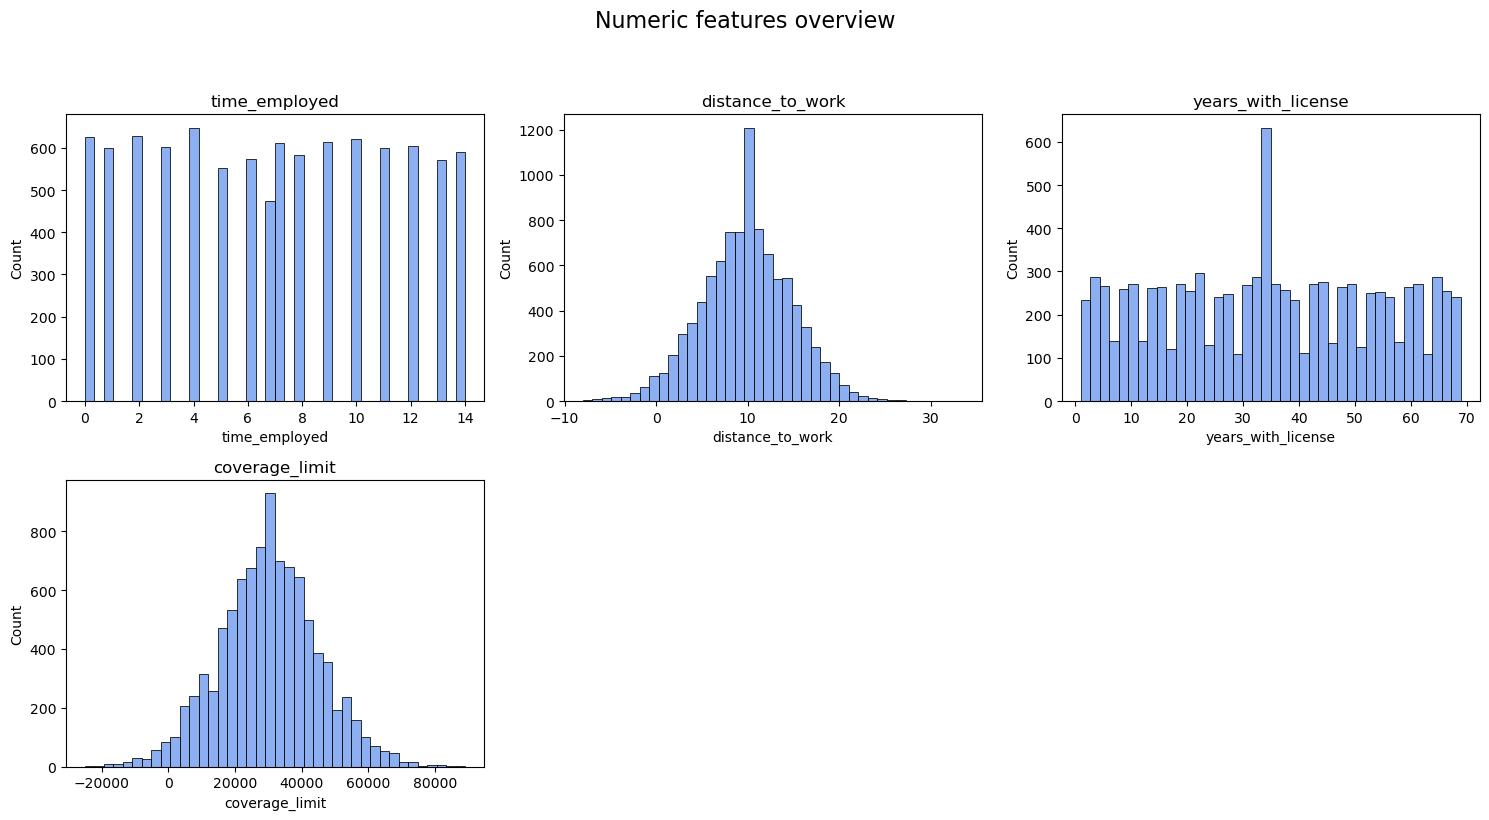

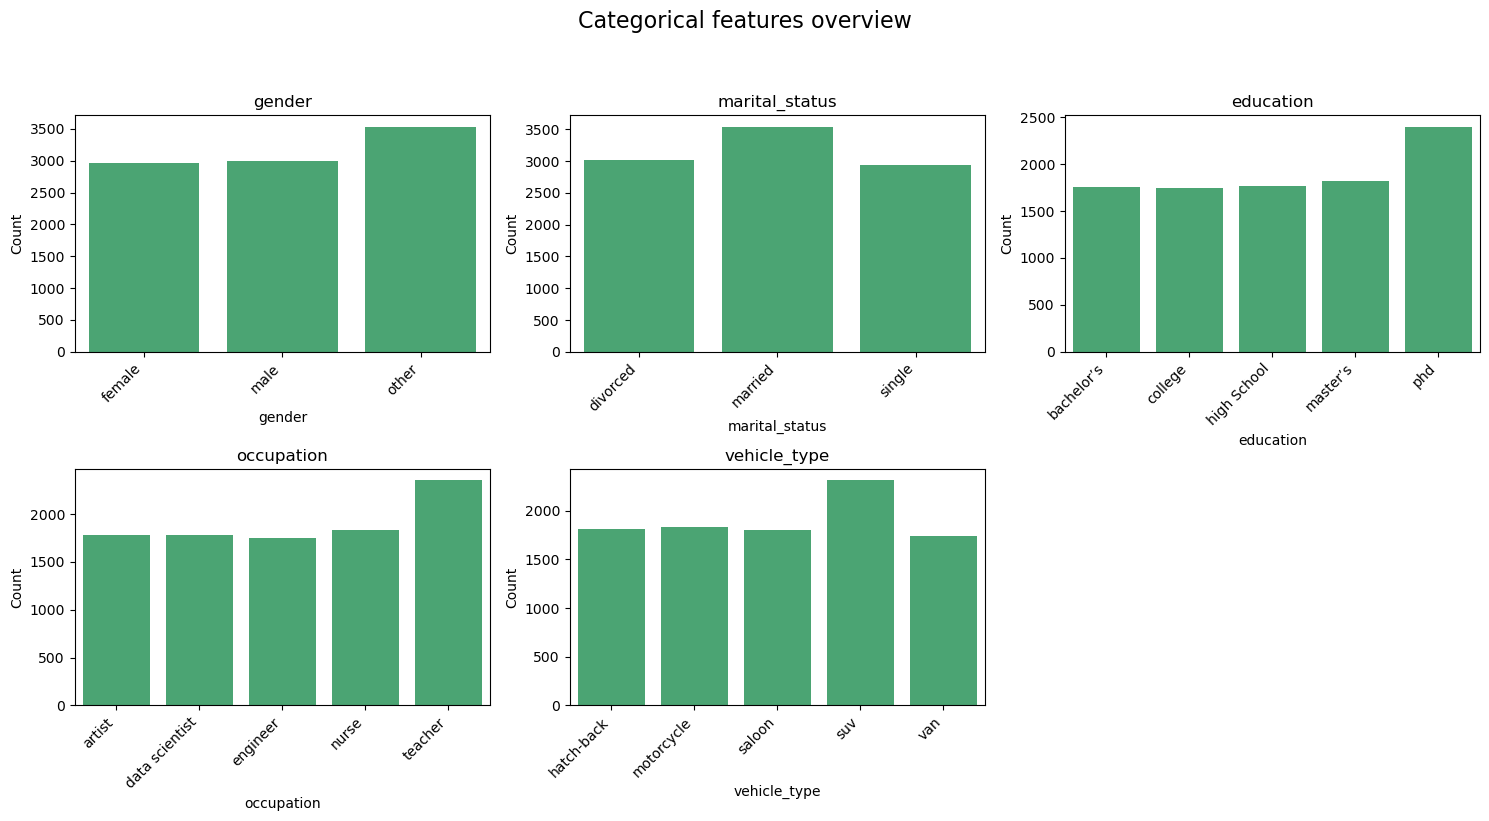

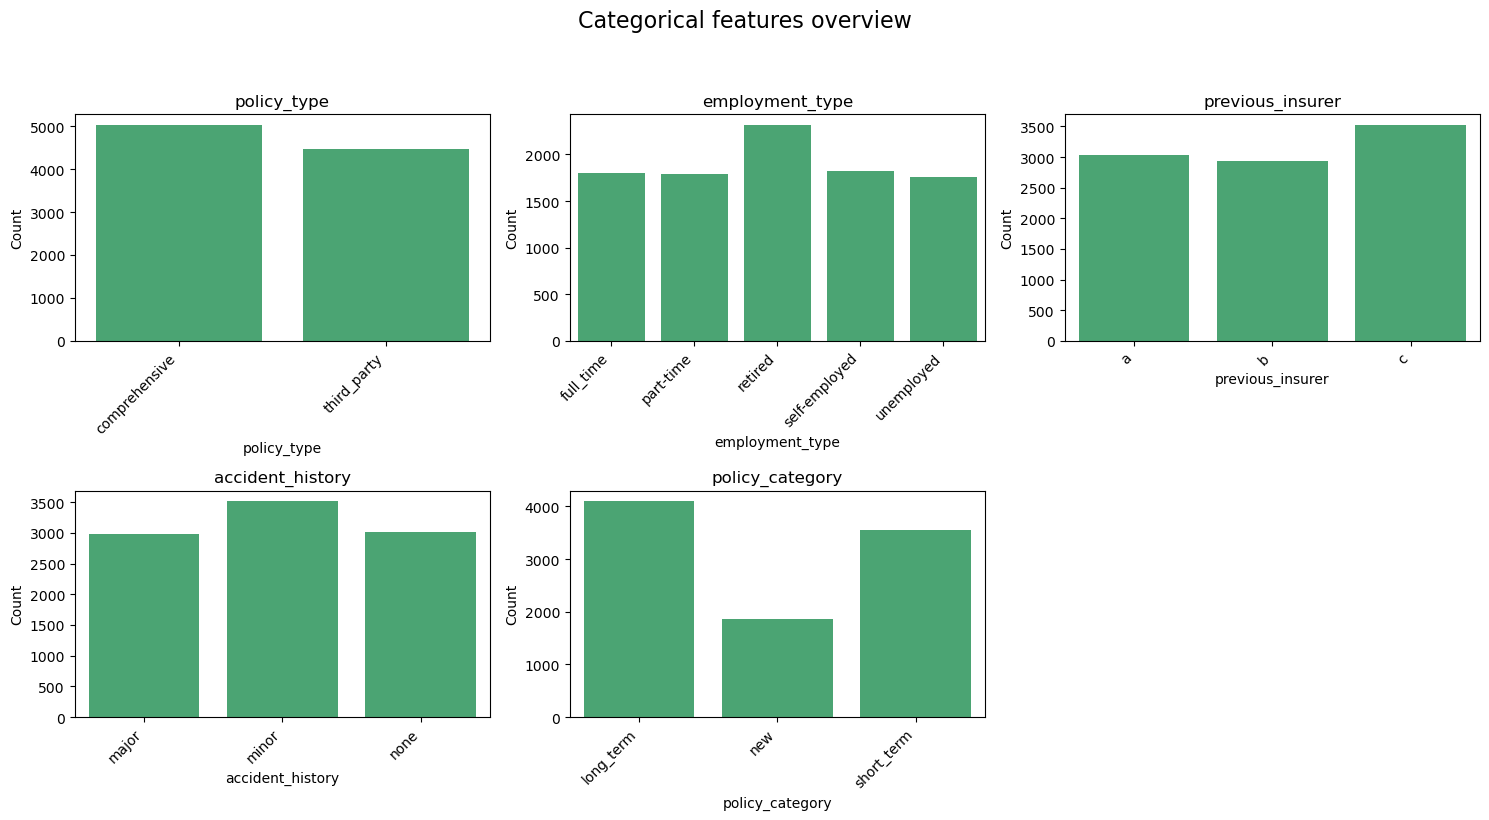

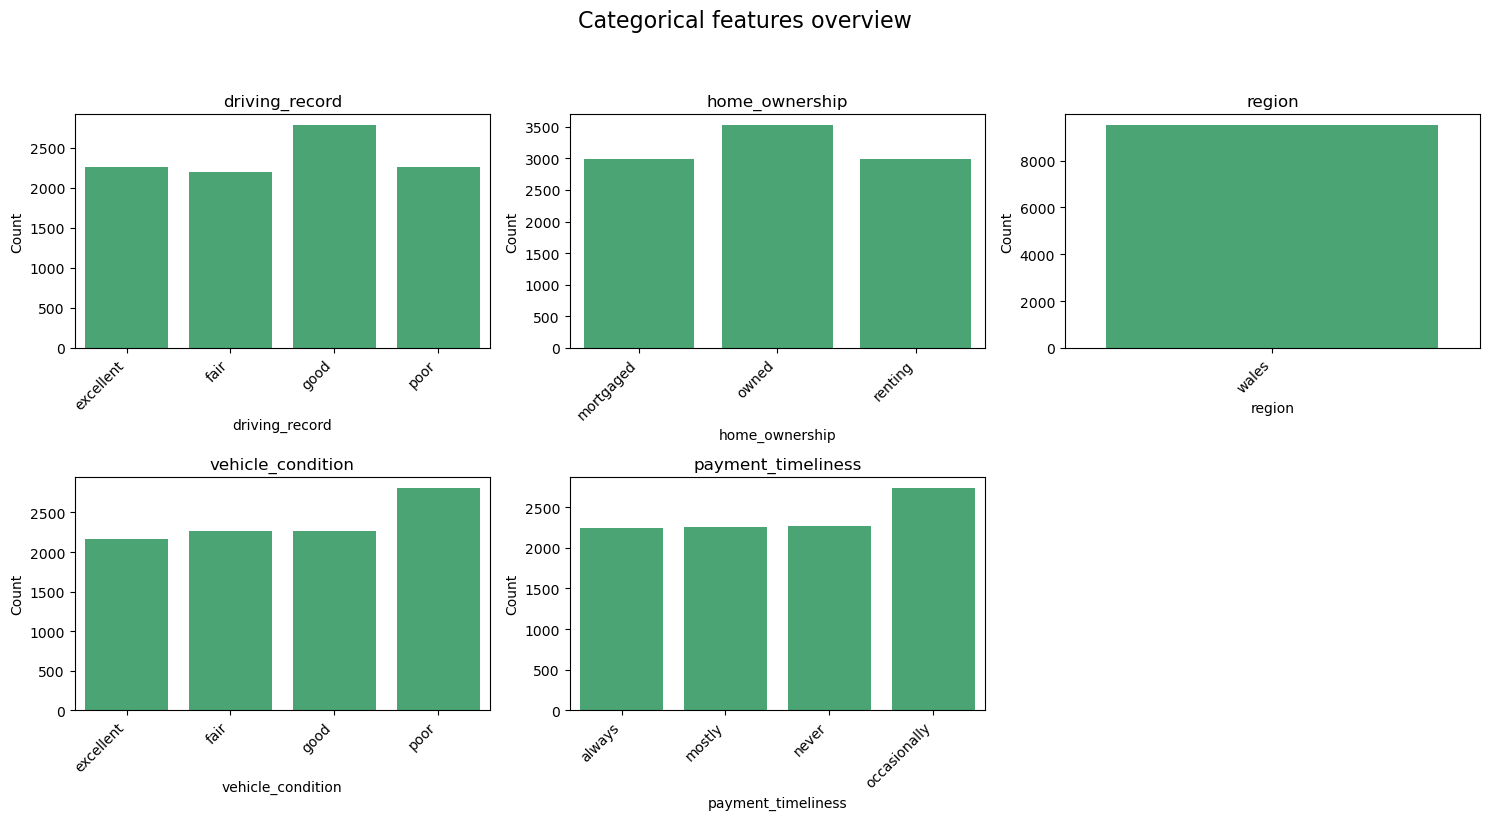

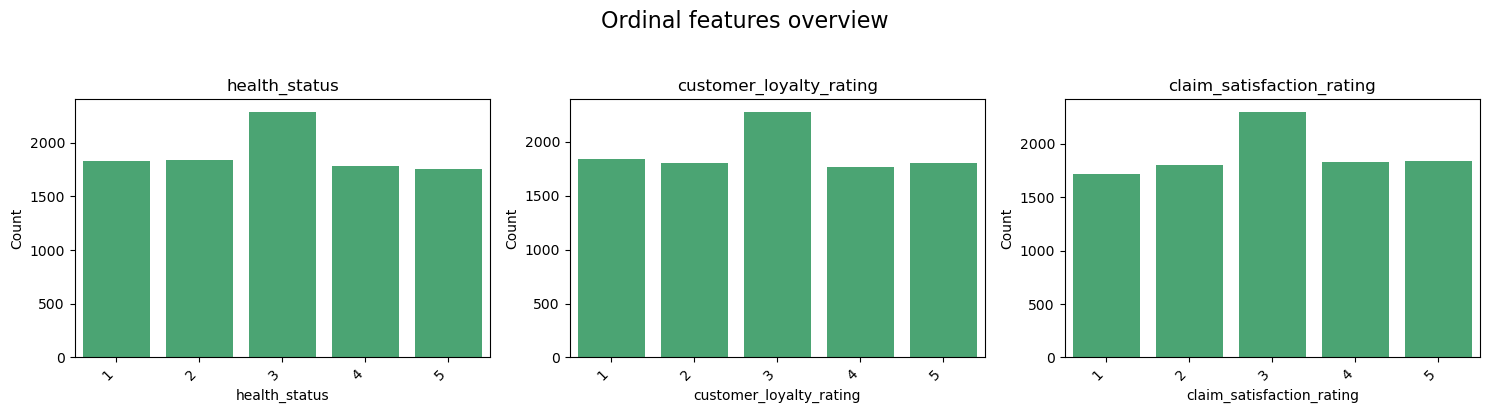

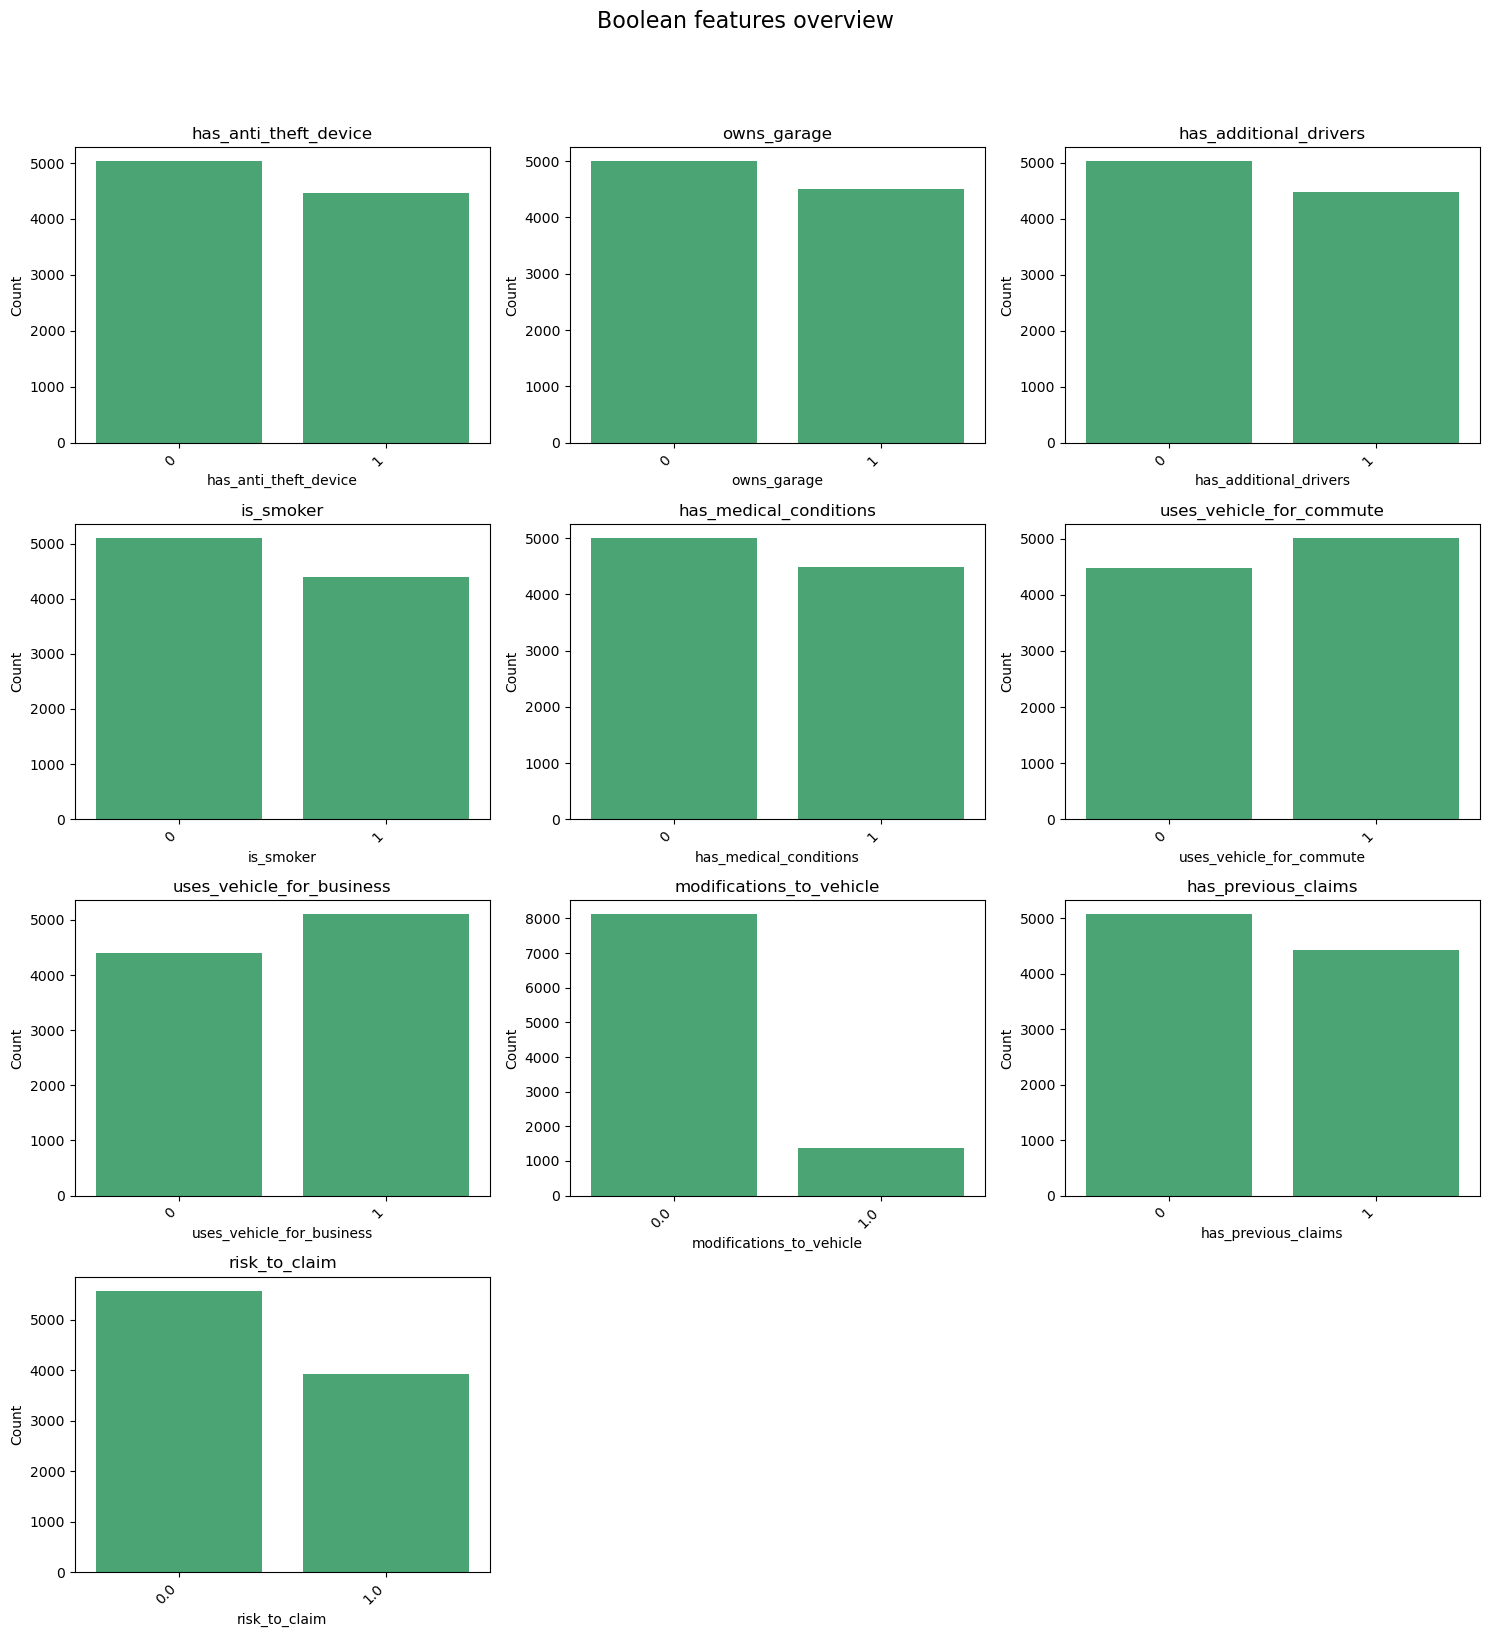

In [262]:
# Feature groups for visualisation
group1_numeric = ['age', 'income', 'credit_score', 'annual_premium', 'vehicle_value'] 
group2_numeric = ['vehicle_age', 'claim_amount_last_year', 'total_claims_past_5_years'] 
group3_numeric = ['time_employed', 'distance_to_work', 'years_with_license', 'coverage_limit']
group4_categorical = ['gender', 'marital_status', 'education', 'occupation', 'vehicle_type']
group5_categorical = ['policy_type', 'employment_type', 'previous_insurer', 'accident_history', 'policy_category'] 
group6_categorical = ['driving_record', 'home_ownership', 'region', 'vehicle_condition', 'payment_timeliness']
group7_ordinal = ['health_status', 'customer_loyalty_rating', 'claim_satisfaction_rating']
group8_boolean = ['has_anti_theft_device', 'owns_garage', 'has_additional_drivers', 'is_smoker',
                  'has_medical_conditions', 'uses_vehicle_for_commute', 'uses_vehicle_for_business',
                  'modifications_to_vehicle', 'has_previous_claims', 'risk_to_claim']

def fix_boolean_and_ordinal(df, bool_cols, ordinal_cols, bool_threshold=0.5, ordinal_range=(1, 5)):
    fixed_bool = []
    fixed_ordinal = []

    # Fix Ordinal columns
    for col in ordinal_cols:
        min_val, max_val = ordinal_range
        unique_vals = df[col].dropna().unique()
        if df[col].dtype in [np.float64, np.int64] and not np.array_equal(unique_vals, unique_vals.astype(int)):
            df[col] = df[col].round().clip(lower=min_val, upper=max_val).astype(int)
            fixed_ordinal.append(col)

    # Fix Boolean columns
    for col in bool_cols:
        unique_vals = df[col].dropna().unique()
        is_binary = np.array_equal(np.sort(unique_vals), [0, 1])
        
        if not is_binary:
            df[col] = (df[col] > bool_threshold).astype(int)
            fixed_bool.append(col)

    print(f"Ordinal fixed: {fixed_ordinal}" if fixed_ordinal else "All ordinal columns were clean.")
    print(f"Boolean fixed: {fixed_bool}" if fixed_bool else "All boolean columns were clean.")
    
    return df

df = fix_boolean_and_ordinal(df, group8_boolean, group7_ordinal)

def smart_subplots(df, features, group_name, cols=3, cardinality_threshold=10):
    rows = (len(features) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Easy iteration even if fewer plots than slots
    plt.suptitle(f"{group_name} overview", fontsize=16, y=1.02)

    for i, feat in enumerate(features):
        ax = axes[i]
        is_numeric = df[feat].dtype in [np.int64, np.float64]
        unique_vals = df[feat].nunique()

        if is_numeric and unique_vals > cardinality_threshold:
            sns.histplot(df[feat], bins=40, ax=ax, color='cornflowerblue')
        else:
            vc = df[feat].value_counts().sort_index()
            sns.barplot(x=vc.index, y=vc.values, ax=ax, color='mediumseagreen')
            ax.set_xticks(np.arange(len(vc.index))) 
            ax.set_xticklabels(vc.index, rotation=45, ha='right')

        ax.set_title(feat)
        ax.set_xlabel(feat)
        ax.set_ylabel("Count")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Numeric groups (histograms)
smart_subplots(df, group1_numeric, 'Numeric features')
smart_subplots(df, group2_numeric, 'Numeric features')
smart_subplots(df, group3_numeric, 'Numeric features')
smart_subplots(df, group4_categorical, 'Categorical features')
smart_subplots(df, group5_categorical, 'Categorical features')
smart_subplots(df, group6_categorical, 'Categorical features')
smart_subplots(df, group7_ordinal, 'Ordinal features')
smart_subplots(df, group8_boolean, 'Boolean features')

3.3 A function is defined to remove outliers, using the Inter-Quartile Range (IQR) - the middle 50% of the data. This method tags values below 1.5x the 25%, or above 1.5x the 75% mark, as outliers.

In [263]:
def get_outlier_mask_iqr(df, col, threshold=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - threshold * IQR
    upper = Q3 + threshold * IQR
    return ~df[col].between(lower, upper)

def compare_outlier_removal_iqr(df, col, threshold=1.5):
    outlier_mask = get_outlier_mask_iqr(df, col, threshold)
    outliers = df[col][outlier_mask]
    clean = df[col][~outlier_mask]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Outlier Impact on '{col}' (IQR Method)", fontsize=14)

    # Left plot: original with outliers highlighted
    sns.histplot(df[col], bins=40, kde=False, color='lightgrey', label='All Data', ax=axes[0])
    sns.histplot(outliers, bins=40, kde=False, color='crimson', label='Outliers', ax=axes[0])
    axes[0].set_title("Original Distribution")
    axes[0].legend()

    # Right plot: cleaned distribution
    sns.histplot(clean, bins=40, kde=False, color='mediumseagreen', ax=axes[1])
    axes[1].set_title("Filtered Distribution")

    plt.tight_layout()
    plt.show()

    removed = outlier_mask.sum()
    total = len(df)
    print(f"Identified {removed} outliers from '{col}' ({removed/total:.2%} of rows)")

3.4 Features can be added here to demonstrate the effect of outlier removal. This bar chart shows the effect on claim amount in the last 12 months.

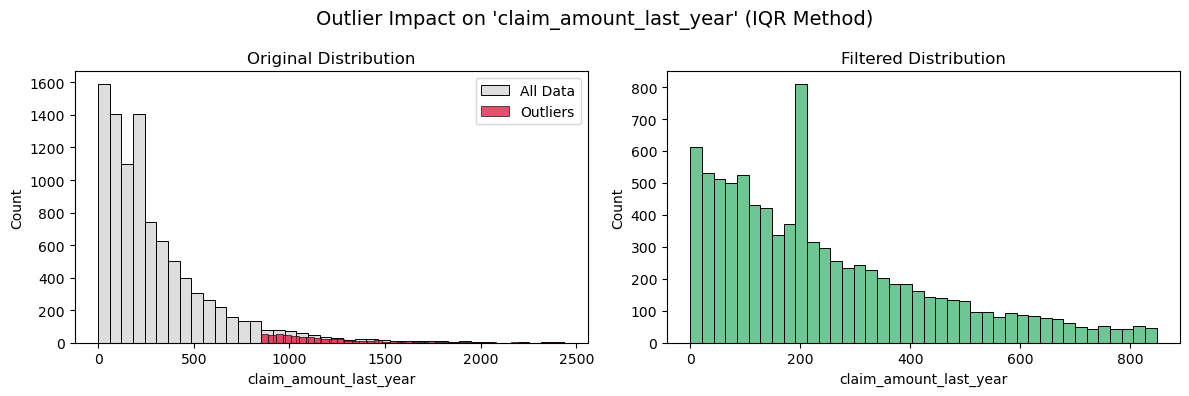

Identified 530 outliers from 'claim_amount_last_year' (5.58% of rows)


In [264]:
compare_outlier_removal_iqr(df, 'claim_amount_last_year')

3.5 Outlier removal can be safely performed based on the above bar chart, or skipped.

In [265]:
# Get mask of rows where 'income' is NOT an outlier
valid_income_mask = ~get_outlier_mask_iqr(df, 'income', threshold=1.5)

# Apply it to your dataframe
df = df[valid_income_mask].reset_index(drop=True)

print(f"Remaining rows after outlier removal: {len(df)}")

Remaining rows after outlier removal: 8720


3.6 Before training a model, ordinal and categorical features need to be converted to numeric values in a method known as encoding. This allows the ML algorithm to understand the data.

In [266]:
categorical_cols = ['gender', 'marital_status', 'education', 'occupation', 'vehicle_type', 
                    'policy_type', 'employment_type', 'previous_insurer', 'accident_history',
                    'has_previous_claims', 'region']
ordinal_cols = ['health_status', 'driving_record', 'home_ownership', 'customer_loyalty_rating', 
                'vehicle_condition', 'payment_timeliness', 'claim_satisfaction_rating',
                'policy_category']

def encode_features(df, categorical_cols, ordinal_cols):
    df_encoded = df.copy()

    # Ordinal encoding (preserving natural order)
    if ordinal_cols:
        df_encoded[ordinal_cols] = OrdinalEncoder().fit_transform(df_encoded[ordinal_cols])

    # Categorical encoding using one-hot
    if categorical_cols:
        df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

    return df_encoded

df_encoded = encode_features(df, categorical_cols, ordinal_cols)

3.7 Feature selection - any features that are highly correlated with each other (using a threshold of 0.7) are removed.

In [267]:
def drop_correlated_features(df, threshold=0.7):
    corr_matrix = df.corr().abs()  # absolute correlation
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find columns with correlation > threshold
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]
    df_reduced = df.drop(columns=to_drop)

    print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")
    return df_reduced

x_cleaned = drop_correlated_features(df_encoded.drop(columns='risk_to_claim'))

Removed 0 highly correlated features: []


3.8 Feature selection - an ML model is built to rank features by importance. Only the top 20 are kept, to keep final model performance high.

In [268]:
model = RandomForestClassifier(random_state=seed)
model.fit(x_cleaned, df['risk_to_claim'])

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=x_cleaned.columns).sort_values(ascending=False)

# Select number of features to keep
top_k = 20
x_reduced = x_cleaned[feat_imp.head(top_k).index]

print(f"Features before selection: {x_cleaned.shape[1]}")
print(f"Features after selection: {x_reduced.shape[1]}")
print(f"\nTop {top_k} features selected, by importance:\n")
print(feat_imp.head(top_k).to_string())


Features before selection: 55
Features after selection: 20

Top 20 features selected, by importance:

vehicle_age                  0.672232
total_claims_past_5_years    0.021060
income                       0.019479
vehicle_value                0.018584
claim_amount_last_year       0.018465
credit_score                 0.018034
annual_premium               0.018009
distance_to_work             0.017324
years_with_license           0.016861
age                          0.016743
coverage_limit               0.015964
time_employed                0.011924
dependents                   0.007439
customer_loyalty_rating      0.007125
health_status                0.006974
claim_satisfaction_rating    0.006956
driving_record               0.005859
payment_timeliness           0.005611
vehicle_condition            0.005598
home_ownership               0.004745


3.9 All features are scaled, to make the data more interpretable. MinMaxScaler scales all values to between 0 and 1, and is robust to any remaining outliers.

In [269]:
# Preserve original feature names before scaling
feature_names = x_reduced.columns.tolist()

scaler = MinMaxScaler()

# Scale and preserve column names
x_scaled = pd.DataFrame(scaler.fit_transform(x_reduced), columns=feature_names)

## 4. Modelling

4.1 The selected features (x), and the target label that we want to predict (y) are shown up front.

In [270]:
# # Feature selection
x = x_scaled

# # Name output/labels for prediction visualisation
output_names = ['risk_to_claim']

# # Target column
y = df['risk_to_claim']

4.2 Train-test split. Data is split into test and train datasets, with stratification used to ensure an even balance of the target value (risk_to_claim) across datasets.

In [271]:
# Split the data into train and test sets
# If classification, stratify to consider y imbalance
x_train_full, x_test_final, y_train_full, y_test_final = train_test_split(
    x, y, test_size=0.2, random_state=seed, stratify=y)

4.3 Training. As the predicted claim is either a 1 or 0, the ML approach used is Classification. A Random Forest algorithm is chosen to train an initial model, and 10-fold cross-validation is used to give a robust metrics - different combinations of the dataset are tested 10 times.

In [272]:
initial_metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

for train_idx, test_idx in kfold.split(x_train_full, y_train_full):
    x_train, x_test = x_train_full.iloc[train_idx], x_train_full.iloc[test_idx]
    y_train, y_test = y_train_full.iloc[train_idx], y_train_full.iloc[test_idx]

    model = RandomForestClassifier(random_state=seed)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    initial_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    initial_metrics['Precision'].append(precision_score(y_test, y_pred))
    initial_metrics['Recall'].append(recall_score(y_test, y_pred))
    initial_metrics['F1 Score'].append(f1_score(y_test, y_pred))

# Aggregate baseline results
initial_summary = pd.DataFrame({
    'Metric': initial_metrics.keys(),
    'Initial CV Avg (%)': np.round([np.mean(initial_metrics[m]) * 100 for m in initial_metrics], 1)
})

4.4 Hyperparameter tuning. A wide range of settings of the model are used as a search space, to tune the model even further and increase performance, finding the best model. Bayesian Optimisation is the method used here to find the optimal settings in an efficient a manner as possible.

In [273]:
search_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Categorical([None, 10, 20, 30]),
    'min_samples_split': Integer(2, 10),
    'max_features': Categorical(['sqrt', 'log2'])
}

# Initialize Bayesian Optimisation
search = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=seed),
    search_spaces=search_space,
    scoring='f1',
    cv=10,
    n_iter=50,
    n_jobs=-1,
    verbose=0,
    random_state=seed
)

# Fit search to training data
search.fit(x_train_full, y_train_full)
best_model = search.best_estimator_

4.5 Final test evaluation. The hold-out 20% test data is used to perform a final test on the best model. Performance metrics between the initial model and the final model are shown to demonstrate the value of tuning. Once performed, the final metrics are available in detail, and a confusion matrix displayed to allow evaluation of the success of the classification model trained.

,Initial CV Avg (%),Tuned Final Test (%)
Metric,,
Accuracy,97.600000,97.000000
Precision,99.600000,97.100000
Recall,94.600000,97.000000
F1 Score,97.000000,97.000000



Interpretation:
- When we flag someone as likely to claim, we're right about 97.1% of the time (Precision).
- We're catching 97.0% of all actual claimants (Recall).
- The model's balanced performance (F1 Score) is 97.0%.
- Overall, 97.0% of predictions are correct (Accuracy) — supporting smarter, lower-risk approvals.



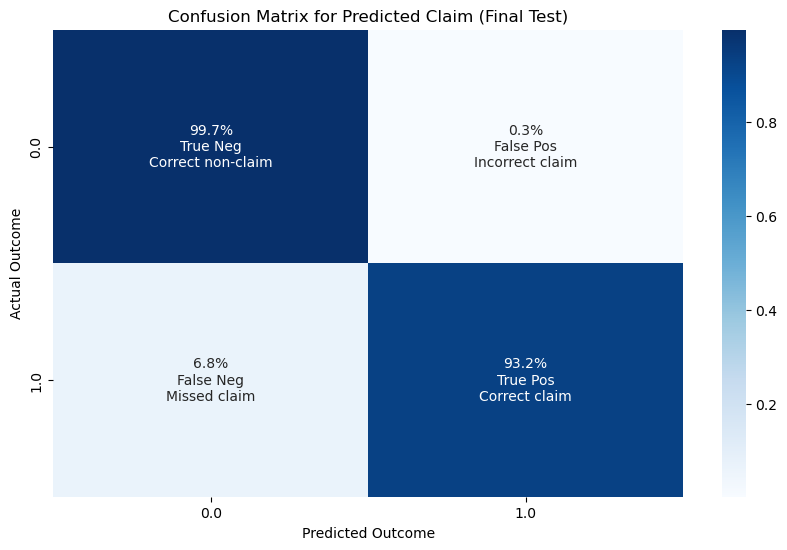

In [274]:
y_pred_final = best_model.predict(x_test_final)
report = classification_report(y_test_final, y_pred_final, output_dict=True)

final_metrics = {
    'Accuracy': round(accuracy_score(y_test_final, y_pred_final) * 100, 1),
    'Precision': round(report['weighted avg']['precision'] * 100, 1),
    'Recall': round(report['weighted avg']['recall'] * 100, 1),
    'F1 Score': round(report['weighted avg']['f1-score'] * 100, 1)
}

final_summary = pd.DataFrame({
    'Metric': final_metrics.keys(),
    'Tuned Final Test (%)': final_metrics.values()
})

comparison_df = initial_summary.set_index('Metric').join(final_summary.set_index('Metric'))
display(comparison_df.style.set_caption("Model Performance: Baseline vs Tuned").background_gradient(cmap="Blues", subset=["Tuned Final Test (%)"]))

print(f"""
Interpretation:
- When we flag someone as likely to claim, we're right about {final_metrics['Precision']}% of the time (Precision).
- We're catching {final_metrics['Recall']}% of all actual claimants (Recall).
- The model's balanced performance (F1 Score) is {final_metrics['F1 Score']}%.
- Overall, {final_metrics['Accuracy']}% of predictions are correct (Accuracy) — supporting smarter, lower-risk approvals.
""")

cm = confusion_matrix(y_test_final, y_pred_final)
cm_percent = cm / cm.sum(axis=1, keepdims=True)

label_annotations = np.array([
    ["True Neg\nCorrect non-claim", "False Pos\nIncorrect claim"],
    ["False Neg\nMissed claim", "True Pos\nCorrect claim"]
])

annot = np.empty_like(cm_percent).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percent = f"{cm_percent[i, j]*100:.1f}%"
        label = label_annotations[i, j]
        annot[i, j] = f"{percent}\n{label}"

labels = sorted(y.unique())
cm_percent_df = pd.DataFrame(cm_percent, index=[f"Actual {i}" for i in labels],
                             columns=[f"Predicted {i}" for i in labels])

plt.figure(figsize=(9, 6))
sns.heatmap(cm_percent_df, annot=annot, fmt="", cmap="Blues",
            xticklabels=labels, yticklabels=labels, annot_kws={"fontsize": 10})
plt.title("Confusion Matrix for Predicted Claim (Final Test)")
plt.xlabel("Predicted Outcome")
plt.ylabel("Actual Outcome")
plt.tight_layout(pad=2.5)
plt.show()

4.6 Feature importance - visualise which features from the insurance dataset are most influential on the output, predicted claim within 12 months.

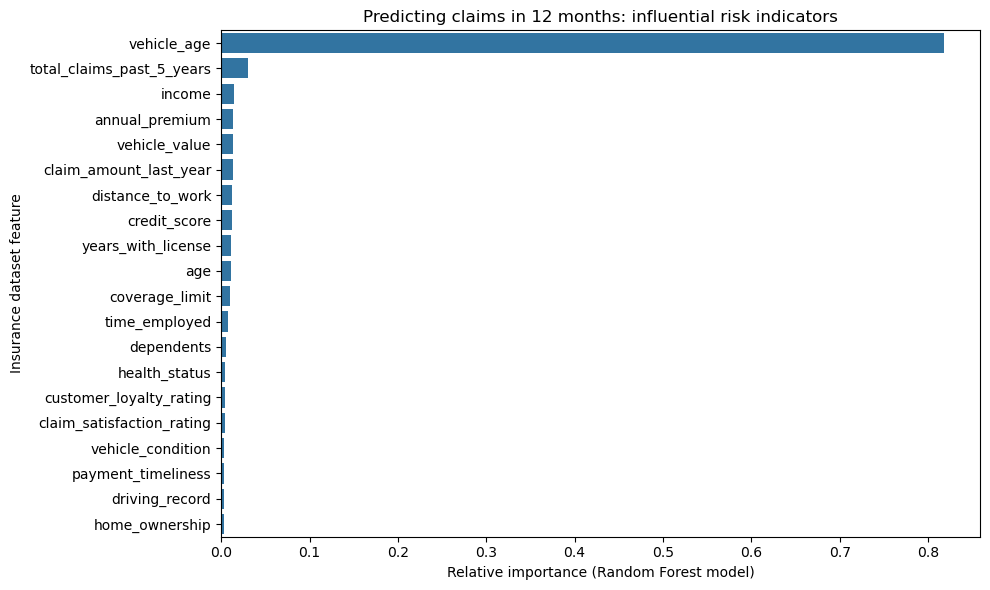

In [275]:
# Get feature importances from trained model
importances = best_model.feature_importances_
features = x_train_full.columns

# Create a DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Predicting claims in 12 months: influential risk indicators')
plt.xlabel('Relative importance (Random Forest model)')
plt.ylabel('Insurance dataset feature')
plt.tight_layout()
plt.show()

##### Explain how the model could be used to ensure only 5% of people that buy a policy would claim on their policy.
Now that a functioning ML model is available, it can be used to score all applicants based on the information they provide the business with. Rather than only predicting whether someone will claim, the model can also output predicted probability of a claim. Applicants are then ranked by their predicted risk, and only those with a risk below a set limit (such as 5%) are accepted. The limit is chosen so that among all accepted applicants, no more than 5% are expected to make a claim, keeping risk low.

The code below shows an example of how this might work, using our test data.

In [276]:
# Predict probabilities for class 1 (claim)
probs = best_model.predict_proba(x_test)[:, 1]

# Build results dataframe
results = x_test.copy()
results['risk_to_claim'] = y_test
results['risk_to_claim_prob'] = probs

# Define threshold of 5% for acceptance
threshold = 0.05

# Accept if predicted risk is low enough
results['accepted'] = results['risk_to_claim_prob'] <= threshold

display(results[['risk_to_claim', 'risk_to_claim_prob', 'accepted']].head())

,risk_to_claim,risk_to_claim_prob,accepted
7955,1.0,0.962381,False
6523,1.0,0.984096,False
2670,1.0,0.981149,False
8032,0.0,0.034408,True
1854,1.0,0.927904,False


## 5. Next steps: Production

##### Assuming the business likes your model, what are the next steps to go from a Jupyter Notebook to a productionised service?
The notebook will need to be converted to a modular .py file, and a pipeline created that includes the model, hyperparameters, and scaling used. The model can then be either deployed to a serving endpoint in the cloud (e.g. on Databricks or Azure ML Studio), or containerised. An app could be developed with a user interface to link to the endpoints using REST, at pace using easy-to-use web frameworks such as Streamlit or Shiny. This could then be deployed via Azure App Services or Docker. If deployed in the cloud, then environments for development, pre-production, and production should be created, with pipelines using GitHub or Azure DevOps for code versioning and collaboration. Testing will need to be done by Subject Matter Experts (SME) to ensure the performance is at a satisfactory level.

##### What are the considerations for ensuring the business can leverage it?
Providing an easy-to-use interface is key. Non-technical users should be easily able to input values that the model requires, and gather the output prediction. It should be integrated with existing business processes as much as possible. Guidance documentation should be available so it is clear what the model can do, but also what it's limitations are, for example regarding input data.

##### What are the steps you would take to provide this to the business?
Summarise the performance of the proof of concept, alongside it's perceived use case. Regular updates should be provided to the teams involved via meetings, to check progress and to ensure it is fit for purpose. The models and/or applications should be demonstrated, and code developed in GitHub/DevOps for backup purposes and to aid iterative design. The models should be rigorously tested on a small scale for assurance before wider rollout.

##### Which traditional teams in a business would you need to speak to?
Subject Matter Experts (SME) as data is only one side of the discussion. IT systems for integration, secure access groups, deployment, and compliance. IP and Legal teams for compliance and security of any trade secrets. Operational teams to ensure smooth implementation and upskilling. Senior Leadership to gain buy-in of the methodology.

##### What is in scope and out of scope for your responsibility?
Data Scientists can carry out end-to-end project work, however there can be a lot of overlap between Data Engineering, Data Science, and Machine Learning Engineering roles, so this should be pre-defined by teams before the work begins. Data Engineers can provide a lot of data preparation ready for a Data Scientist to start building ML models. ML Engineers can take proof of concept models and deploy them into production, testing code and improving it before building a structure to retrain the models as new data becomes available, before monitoring performance over time using key metrics used in this notebook as well as R-squared and Root Mean Squared Error (RMSE) for regression problems.